# Parcial Practico 1

## Ernesto Camacho Arroyave - MIND 2022-1

In [419]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from math import ceil
from random import randint

**1) Describa de forma clara y precisa el dataset que le fue asignado. Complementando con la dimensionalidad, la cantidad de atributos, la descripción de clase, cómo utilizarlo
en un problema de clasificación, etc.**

- El dataset que me correspondio es llamado **Car Evaluation**, se encuentra en: https://archive.ics.uci.edu/ml/datasets/car+evaluation .
- Segun la informacion que provee la misma pagina podemos ver: 
    - Que es un dataset multivariado, es decir que tiene distintos tipos de datos 
    - Que tiene un numero de 1728 entradas 
    - Que tiene un total de 6 atributos y una clase:
        - buying el precio de compra
        - maint el costo del mantenimiento
        - doors numero de puertas que tiene
        - persons capacidad de personas que tiene el vehiculo 
        - lug_boot la capacidad que tiene el bául 
        - safety que tan seguro es el vehiculo
        - class que tan aceptable es el vehiculo teniendo en cuenta las caracteristicas
    - Que segun la pagina no tiene valores que faltan, es decir es una dataset completo
- Dado que tiene una clase la idea seria crear un modelo que teniendo en cuenta las caracteristicas para determinar si el vehiculo vale la pena de comprar, rentar, o usar.

In [420]:
carDt= pd.read_csv('car.csv')
carDt.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [421]:
print(carDt.size)
print(carDt.shape)
print(carDt.ndim)

12096
(1728, 7)
2


**2) Comenzando con el preprocesamiento, usted debe decidir si necesario hacer normalización, discretización, selección de atributos, etc. La decisión de hacerlo o no, debe ser justificada.**

- Teniendo en cuenta los atributos, y que los valores que pueden tomar son relativamente pequeños, creo que discretizar los valores de los atributos cualitativos y volverlos cuantitavivos simplificara el analisis y perimitira crear un modelo que sea mas facil de adaptar.

- La discretización de los artributos dependera de los valores de los atributos, pero para cada uno se va a hacer una explicación:
    - **buying:** Este atributo puede tener valores **{vhigh, high, med, low}**, estos valores van a ser mapeados de la siguiente manera **{vhigh = 1, high = 2, med = 3, low = 4}**.
    - **maint:** Este atributo puede tener valores **{vhigh, high, med, low}**, estos valores van a ser mapeados de la siguiente manera **{vhigh = 1, high = 2, med = 3, low = 4}**.
    - **doors:** Es un atributo que por lo general es quantitativo y discreto, pero puede tomar un valor ***5-more***, para este caso lo vamos a pasar a solo numerico y que tome un valor de **5**
    - **persons:** Similar a doors, pero para este caso el valor es ***more***, en este caso lo pasaremos a **5** 
    - **lug_boot:** Este atributo puede tener valores **{small, med, big}**, estos valores van a ser mapeados de la siguiente manera **{small = 1, med = 2, big = 3}**
    - **safety:** Este atributo puede tener valores **{low, med, high}**, estos valores van a ser mapeados de la siguiente manera **{low = 1, med = 2, high = 3}**
    - **class:** La clase puede tomar valores **{unacc, acc, good, vgood}**, estos valores van a ser mapeados de la siguiente manera **{unacc = 1, acc = 2, good = 3, vgood =4 }**.

- Copiamos el data set para no dañarlo, y empezamos a hacer el mapeo de los datos.

In [422]:
carDtMap= carDt.copy()

In [423]:
def doors_persons_mapper(x):
    if (x == '5more') or (x== 'more'):
        y= 5
    else:
        y= int(x)
    return y

In [424]:
# Mapeo de buyingMap
carDtMap['buyingMap'] = carDtMap['buying'].map({'vhigh': 1, 'high': 2, 'med': 3, 'low': 4})

# Mapeo de maintMap
carDtMap['maintMap'] = carDtMap['maint'].map({'vhigh': 1, 'high': 2, 'med': 3, 'low': 4})

# Mapeo de doors
carDtMap['doorsMap'] = carDt['doors'].apply(doors_persons_mapper)

# Mapeo de persons
carDtMap['personsMap'] = carDt['persons'].apply(doors_persons_mapper)

# Mapeo de lug_boot
carDtMap['lug_bootMap'] = carDtMap['lug_boot'].map({'small': 1, 'med': 2, 'big': 3})

# Mapeo de safety
carDtMap['safetyMap'] = carDtMap['safety'].map({'low': 1, 'med': 2, 'high': 3})


In [425]:
carDtMap.tail()

,buying,maint,doors,persons,lug_boot,safety,class,buyingMap,maintMap,doorsMap,personsMap,lug_bootMap,safetyMap
1723,low,low,5more,more,med,med,good,4,4,5,5,2,2
1724,low,low,5more,more,med,high,vgood,4,4,5,5,2,3
1725,low,low,5more,more,big,low,unacc,4,4,5,5,3,1
1726,low,low,5more,more,big,med,good,4,4,5,5,3,2
1727,low,low,5more,more,big,high,vgood,4,4,5,5,3,3


In [426]:
to_drop=['buying','maint','doors','persons','lug_boot','safety'] 
carDtMap.drop(to_drop, inplace= True, axis= 1)
carDtMap.head()

,class,buyingMap,maintMap,doorsMap,personsMap,lug_bootMap,safetyMap
0,unacc,1,1,2,2,1,1
1,unacc,1,1,2,2,1,2
2,unacc,1,1,2,2,1,3
3,unacc,1,1,2,2,2,1
4,unacc,1,1,2,2,2,2


**3) Insertar de manera aleatoria en su dataset preprocesado un 10% de missing values excluyendo la clase.
El porcentaje es relacionado con la dimesionalidad, e.g., dim(DS) = (20, 5), el 10% es tener NA en 10
celdas aleatorias.**

In [427]:
print(carDtMap.size)
print(carDtMap.shape)
print(carDtMap.ndim)

12096
(1728, 7)
2


- Podemos ver que hay un total de 12096 celdas si necesitamos el 10% de eso solo es calcularlo.

In [428]:
print(12096 * 0.1)

1209.6000000000001


- Para poder tener un numeo entero para manejar, usaremos la funcion techo y usaremos el valor que ese no provee para determinar el numero de celdas que deben tener un valor faltante

In [429]:
print(ceil(12096 * 0.1))

1210


- Con un valor de 1210 tenemos el numero de celdas que deben quedar faltantes.

In [430]:
def randomNone(number, dataset):
    row,cols= dataset.shape
    columnName= dataset.columns
    num= 0
    while num < number:
        randRow= randint(0,row-1)
        randCol= columnName[randint(1,cols-1)]
        dataset.loc[randRow,randCol]= None
        num += 1
    return dataset

- Con la funcion para poner valores aleatorios en nulo, vamos a confirmar que nuestro data set antes de ser expuesto a la funcion es correcto y no le falta ningun valor.

<AxesSubplot:>

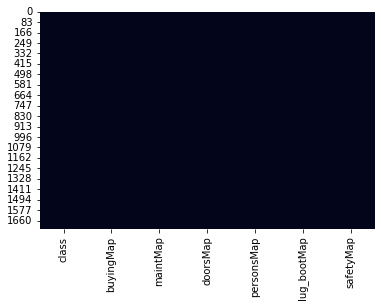

In [431]:
sns.heatmap(carDtMap.isnull(), cbar=False)

- Confirmando que no hay nada faltante, usaremos la funcion

In [432]:
carDtMapRandom= carDtMap.copy()

In [433]:
carDtMapRandom= randomNone(1210,carDtMapRandom)

<AxesSubplot:>

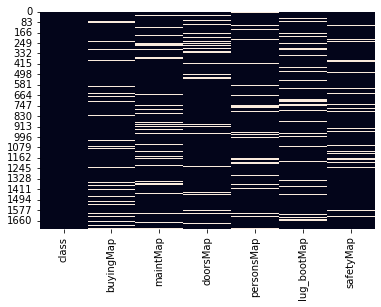

In [434]:
sns.heatmap(carDtMapRandom.isnull(), cbar=False)

- Como podemos observar, los valores efectivamente fueron alterados, insertando valores nulos en el dataset

**4) Hacer la imputación por alguna técnica basada en cálculo estadístico como media, mediana o moda.**

- Para este punto, el metodo de imputación va a ser la moda, mas que nada porque considero que utilizar la mediana nos quitaria mucha información, y usar la media nos podria resultar valores decimales, lo que implicaria que introduciriamos otro tipo de datos al dataset, lo que considero lo hace mas desordenado. 

- Empezamos la imputación de los datos 

In [435]:
carDtMapRandomStat= carDtMapRandom.copy()

In [436]:
values= carDtMapRandomStat ['buyingMap'].value_counts()
print(values)
values= values.index.to_list()
carDtMapRandomStat['buyingMap']= carDtMapRandomStat['buyingMap'].replace(np.nan,values[0])
print('### ### ###')
values= carDtMapRandomStat ['buyingMap'].value_counts()
print(values)

1.0    392
2.0    389
4.0    389
3.0    383
Name: buyingMap, dtype: int64
### ### ###
1.0    567
2.0    389
4.0    389
3.0    383
Name: buyingMap, dtype: int64


In [437]:
values= carDtMapRandomStat ['maintMap'].value_counts()
print(values)
values= values.index.to_list()
carDtMapRandomStat['maintMap']= carDtMapRandomStat['maintMap'].replace(np.nan,values[0])
print('### ### ###')
values= carDtMapRandomStat ['maintMap'].value_counts()
print(values)

2.0    390
4.0    383
1.0    379
3.0    374
Name: maintMap, dtype: int64
### ### ###
2.0    592
4.0    383
1.0    379
3.0    374
Name: maintMap, dtype: int64


In [438]:
values= carDtMapRandomStat ['doorsMap'].value_counts()
print(values)
values= values.index.to_list()
carDtMapRandomStat['doorsMap']= carDtMapRandomStat['doorsMap'].replace(np.nan,values[0])
print('### ### ###')
values= carDtMapRandomStat ['doorsMap'].value_counts()
print(values)

2.0    388
4.0    388
5.0    382
3.0    377
Name: doorsMap, dtype: int64
### ### ###
2.0    581
4.0    388
5.0    382
3.0    377
Name: doorsMap, dtype: int64


In [439]:
values= carDtMapRandomStat ['personsMap'].value_counts()
print(values)
values= values.index.to_list()
carDtMapRandomStat['personsMap']= carDtMapRandomStat['personsMap'].replace(np.nan,values[0])
print('### ### ###')
values= carDtMapRandomStat ['personsMap'].value_counts()
print(values)

5.0    523
4.0    512
2.0    507
Name: personsMap, dtype: int64
### ### ###
5.0    709
4.0    512
2.0    507
Name: personsMap, dtype: int64


In [440]:
values= carDtMapRandomStat ['lug_bootMap'].value_counts()
print(values)
values= values.index.to_list()
carDtMapRandomStat['lug_bootMap']= carDtMapRandomStat['lug_bootMap'].replace(np.nan,values[0])
print('### ### ###')
values= carDtMapRandomStat ['lug_bootMap'].value_counts()
print(values)

1.0    522
2.0    507
3.0    505
Name: lug_bootMap, dtype: int64
### ### ###
1.0    716
2.0    507
3.0    505
Name: lug_bootMap, dtype: int64


In [441]:
values= carDtMapRandomStat ['safetyMap'].value_counts()
print(values)
values= values.index.to_list()
carDtMapRandomStat['safetyMap']= carDtMapRandomStat['safetyMap'].replace(np.nan,values[0])
print('### ### ###')
values= carDtMapRandomStat ['safetyMap'].value_counts()
print(values)

3.0    521
2.0    516
1.0    508
Name: safetyMap, dtype: int64
### ### ###
3.0    704
2.0    516
1.0    508
Name: safetyMap, dtype: int64


<AxesSubplot:>

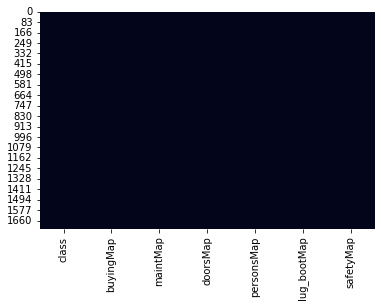

In [442]:
sns.heatmap(carDtMapRandomStat.isnull(), cbar=False)

- Podemos ver que los valores fueron imputados correctamente

**5) Hacer dos imputaciones por la técnica kNN, con k = 3 y k = 10.**

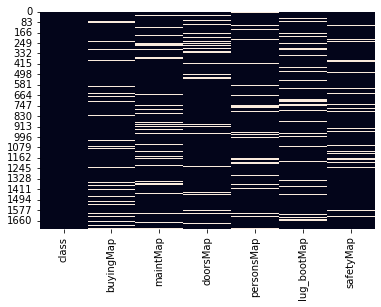

In [443]:
carDtMapRandomKnn3= carDtMapRandom.copy()
sns.heatmap(carDtMapRandomKnn3.isnull(), cbar=False)
cols= ['buyingMap','maintMap','doorsMap','personsMap','lug_bootMap','safetyMap'] 

In [444]:
knn3= KNNImputer(n_neighbors=3)
knn3.fit(carDtMapRandomKnn3[cols])
carDtMapRandomKnn3[cols]=knn3.transform(carDtMapRandomKnn3[cols])

<AxesSubplot:>

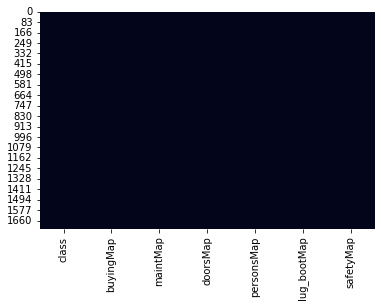

In [445]:
sns.heatmap(carDtMapRandomKnn3.isnull(), cbar=False)

<AxesSubplot:>

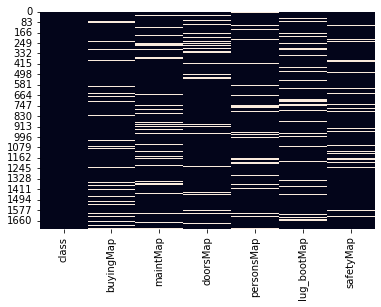

In [446]:
carDtMapRandomKnn10= carDtMapRandom.copy()
sns.heatmap(carDtMapRandomKnn10.isnull(), cbar=False)

In [447]:
knn10= KNNImputer(n_neighbors=10)
knn10.fit(carDtMapRandomKnn10[cols])
carDtMapRandomKnn10[cols]=knn10.transform(carDtMapRandomKnn10[cols])

<AxesSubplot:>

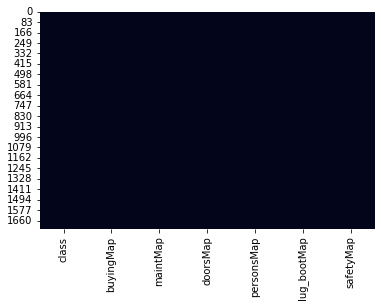

In [448]:
sns.heatmap(carDtMapRandomKnn10.isnull(), cbar=False)

**6) Hacer una función en que permita calcular el error MSE (Mean Square Error) para cada atributo.**

- Dado que tenemos 3 imputaciones sobre el dataset, realizaremos los calculos para las 3 imputaciones, siguiendo el orden de creación.
- Se encontro una funcion que ya hace el calculo solicitado en Sklearn.Metrics, en la pagina de la documentación: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
- Aproximaremos el valor de MSE a 2 cifras decimales, para comodidad de uso

In [449]:
for col in cols:
    mse= mean_squared_error(carDtMap[col],carDtMapRandomStat[col])
    print("El valor de MSE para la columna " + col + " es: " + "%.2f" % mse) 

El valor de MSE para la columna buyingMap es: 0.36
El valor de MSE para la columna maintMap es: 0.18
El valor de MSE para la columna doorsMap es: 0.39
El valor de MSE para la columna personsMap es: 0.40
El valor de MSE para la columna lug_bootMap es: 0.20
El valor de MSE para la columna safetyMap es: 0.19


- Con el primer set de MSE calculado, podemos observar que hay diferentes porcentages, pero podemos ver un porcentage de error bastante alto en el atributo "buyingMap", esto podria ser una razón para descartar esta imputación

In [450]:
for col in cols:
    mse= mean_squared_error(carDtMap[col],carDtMapRandomKnn3[col])
    print("El valor de MSE para la columna " + col + " es: " + "%.2f" % mse) 

El valor de MSE para la columna buyingMap es: 0.34
El valor de MSE para la columna maintMap es: 0.29
El valor de MSE para la columna doorsMap es: 0.20
El valor de MSE para la columna personsMap es: 0.26
El valor de MSE para la columna lug_bootMap es: 0.10
El valor de MSE para la columna safetyMap es: 0.10


- El segundo set de MSE, podemos observar que de nuevo el valor de "buyingMap" es bastante alto, sin embargo hay una mejoria con respecto al anterior

In [451]:
for col in cols:
    mse= mean_squared_error(carDtMap[col],carDtMapRandomKnn10[col])
    print("El valor de MSE para la columna " + col + " es: " + "%.2f" % mse) 

El valor de MSE para la columna buyingMap es: 0.15
El valor de MSE para la columna maintMap es: 0.18
El valor de MSE para la columna doorsMap es: 0.17
El valor de MSE para la columna personsMap es: 0.22
El valor de MSE para la columna lug_bootMap es: 0.09
El valor de MSE para la columna safetyMap es: 0.09


**7) Luego de hacer la imputación en los numerales 3 y 4, se tienen 3 datasets con imputaciones diferentes:
DSImpStats, DSImpK3, DSImpK10. Para cada uno encuentre el respectivo MSE y con base en ese valor
determine cual de los 3 datasets imputados usted elige para seguir con el proceso. La elección debe
ser justificada.**

- El ultimo set de MSE, podemos observar que no solo el valor de "buyingMap" bajo de una manera considerable, sino que tambien ninguno de los deas atributos supera el 23% de error, y en general esta mas balceado.
- Con estos valores, tenemos 3 opciones para elegir, personalemente, tengo 2 que me interesan bastante:
    - El dataset de valores estadisticos, dado que por lo que se puede observar es el que para 4 de 6 atributos tiene el menor porcentage de error-
    - El dataset de Knn con 10 vecinos, dado que aunque sus valores estan por los 20%, es que mas balanceado parece estar, no hay un atributo que sea muy alto.
- Considero que el mejor dataset para avanzar el analisis, es el dataset Knn con 10 vecinos.